Use as ref all words from the Linux American dictionary with 5 words (uppercase)

In [2586]:
# we need unidecode to fix accents in certain words
# !pip install unidecode
import unidecode

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 7, 6
rcParams['figure.dpi'] = 60

import warnings
warnings.filterwarnings("ignore")


### Load words from dictionaries to be tested

In [2587]:
# source
# 'https://github.com/hannahcode/wordle/blob/main/src/constants/wordlist.ts'

words_by_dictionary = {}

for n_letters = range(3, 5):
for name, path in zip(['wordle', 'american'], ['data/wordle_list.txt', 'data/american-english']):
    words = [r.strip() for r in open('data/wordle_list.txt')]
    words = [r.upper() for r in words if len(r) == 5 and not '\'' in r]
    words = [unidecode.unidecode(w) for w in words]

    n_letters = 5 # reduce to 4 or 3 to debug smaller runs

    if n_letters < 5:
        shorter_words = []
        for w in words:
            for i in range(5 - n_letters + 1):
                wi = w[i: i + n_letters]
                shorter_words.append(wi)
        words = shorter_words

    words = list(set([w[:n_letters] for w in words])) # removing duplicates # in case reducing the dictionary complexity


    n_sample = None # 1000 # None # 1000 # None
    # random.seed()


    print('# total words', len(words))
    if n_sample is not None:
        words = random.sample(words, n_sample)


    print('# words in sample', len(words))
    
    words_by_dictionary[name + '_' + str(n_letters)] = words
    # words = words[:n_sample]

SyntaxError: invalid syntax (<ipython-input-2587-4664b6a3d8f7>, line 6)

#### Main util functions (rules, selection and scoring)

In [ ]:
def get_rules(query_word, target_word):
    i = 0
    rules = []
    for qi, ti in zip(query_word, target_word):
        if qi == ti:
            rules.append([qi, i, True])
        else:
            if qi in target_word:
                rules.append([qi, -1, True])
                rules.append([qi, i, False])
            else:
                rules.append([qi, -1, False])            
        i += 1
    return rules

def select_one_rule(words, rule):
    letter, position, mask = rule
    if mask:
        return [w for w in words if ((w[position] == letter) if position != -1 else letter in w)]
    return [w for w in words if ((w[position] != letter) if position != -1 else letter not in w)]

def select_multiple_rules(words, rules, log=False):
    if log:
        print('# query words', len(words))
    remaining_words = [w for w in words]
    for ri, r in enumerate(rules):
        remaining_words = select_one_rule(remaining_words, r)
    if log:
        print('after rule %s: %i words' % (r, len(remaining_words)))
    return remaining_words

def get_guesses(words, challenge_word, queries):
    words_by_guess = {}
    for wi, guess in enumerate(queries):
        # if wi % 100 == 0:
        #     print(wi)
        words_by_guess[guess] = select_multiple_rules(words, get_rules(guess, challenge_word))
    return words_by_guess

def score_guesses(words_by_guess):
    res  = []
    for gi, guess in enumerate(words_by_guess):
        #         if gi % 10 == 0:
        #             print(gi)
        remaining_words = words_by_guess[guess]
        # print(guess, len(remaining_words))
        
        med = np.nan
        if len(remaining_words) > 1:
            med = get_med_cluster_size(remaining_words)
        res.append([guess, len(remaining_words), med])
    # print('med', med)
    res = pd.DataFrame(res, columns=['guess', 'words.left', 'median.size'])
    res = res.sort_values('words.left')
    return res


#### Clustering util functions (distance, mutual information, clustering)

In [ ]:
from sklearn.metrics import mutual_info_score

def dist(a, b):
    assert len(a) == len(b)
    return len(a) - sum(ai == bi for ai, bi in zip(a, b))

def get_dism(words):
    entries = []
    for i, a in enumerate(words):
        for j, b in enumerate(words):
            if j < i:
                continue
            d = dist(a, b)
            entries.append([i, j, d])
            if i != j:
                entries.append([j, i, d])

    df_dism = pd.DataFrame(entries, columns=['i', 'j', 'd'])
    df_dism = df_dism.pivot('i', 'j', 'd')
    return df_dism

def get_mut_info(words):
    n_letters = len(words[0])
    df = pd.DataFrame([[letter for letter in w] for w in words])
    freq = pd.Series(df.values.flatten()).value_counts().sort_values()
    df['score'] = [sum([freq[c] for c in set(w)]) for w in words]
    df['word'] = words
    
    # calculate mutual information between words, iteratively
    letter_m = []
    for pi in range(n_letters):
        for pj in range(n_letters):
            if pj > pi:
                continue
            for a in freq.index:
                for b in freq.index:
                    v1, v2 = df['word'].str[pi].str.contains(a), df['word'].str[pj].str.contains(b)
                    mut_info = np.log10(mutual_info_score(v1, v2) + 1e-10)
                    # mut_info = mutual_info_score(v1, v2)
                    letter_m.append([a + str(pi), b + str(pj), mut_info])
                    letter_m.append([b + str(pj), a + str(pi), mut_info])

                    
    dism = pd.DataFrame(letter_m, columns=['a', 'b', 'mut.info'])
    dism['k'] = dism['a'] + dism['b']
    dism = dism.drop_duplicates('k')
    del dism['k']
    dism = dism.pivot('a', 'b', 'mut.info')
    return dism

# return the higher size of groups upon clustering and assessment at different thresholds
def get_scores(cg, df, min_thr=0, max_thr=200, step=10):
    res = []
    for thr in range(0, 200, 10):
        # print(thr)
        try:
            plt.close()
            den = scipy.cluster.hierarchy.dendrogram(cg.dendrogram_row.linkage,
                                                     labels = df.index,
                                                     color_threshold=thr / 100)
            plt.close()
            from collections import defaultdict


            def get_cluster_classes(den, label='ivl'):
                cluster_idxs = defaultdict(list)
                for c, pi in zip(den['color_list'], den['icoord']):
                    for leg in pi[1:3]:
                        i = (leg - 5.0) / 10.0
                        if abs(i - int(i)) < 1e-5:
                            cluster_idxs[c].append(int(i))

                cluster_classes = {}
                for c, l in cluster_idxs.items():
                    i_l = [den[label][i] for i in l]
                    cluster_classes[c] = i_l

                return cluster_classes

            clusters = get_cluster_classes(den);
            cluster = []
            for i in df.index:
                included=False
                for j in clusters.keys():
                    if i in clusters[j]:
                        cluster.append(j)
                        included=True
                if not included:
                    cluster.append(None)

            df["cluster"] = cluster

            med = pd.Series(cluster).value_counts().median()
            res.append([thr, med])
        except Exception:
            res.append([thr, np.nan])
            
    res = pd.DataFrame(res, columns=['thr', 'median'])
    return res.sort_values('median', ascending=True)


def get_med_cluster_size(words):
    df = pd.DataFrame([[letter for letter in w] for w in words])
    dism = get_dism(words)
    linkage = hc.linkage(sp.distance.squareform(dism), method='average')
    cg = sns.clustermap(dism, row_linkage=linkage, col_linkage=linkage)
    med = get_scores(cg, df)['median'].values[0]
    return med

### If having multiple cores, this function is used to parallelize calculations

In [ ]:
import multiprocessing
from multiprocessing import Process
from multiprocessing import Manager
import threading
from threading import Thread
import pandas as pd
import numpy as np
import os
import random
import tempfile
from os.path import join
import screg as scr

class ThreadingUtils:
    @staticmethod
    def chunks(l, n):
        """Yield successive n-sized chunks from l."""
        for i in range(0, len(l), n):
            yield l[i:i + n]

    @staticmethod
    def run(function, input_list, n_cores, log_each=None, log=False,
            input_list_kwargs=None):
        print(('run function %s with n_cores = %i' % (function, n_cores)))
        print(function)
        # print 'with input list of len'
        # print len(input_list)
        # print 'in groups of %d threads' % n_threads

        assert n_cores <= 20

        # the type of input_list has to be a list. If not
        # then it can a single element list and we cast it to list.
        if not isinstance(type(input_list[0]), type(list)):
            input_list = [[i] for i in input_list]

        n_groups = int(len(input_list) / n_cores + 1)
        # print 'n groups', n_groups

        n_done = 0
        
        print('# Total groups', n_groups)
        for group_i in range(n_groups):
            start, end = group_i * n_cores, (group_i + 1) * n_cores
            
            if group_i % 10 == 0:
                print('Current group %i (start/end)' % group_i, start, end)
            # print 'start', start, 'end', end

            threads = [None] * (end - start)
            for i, pi in enumerate(range(start, min(end, len(input_list)))):
                next_args = input_list[pi]
                next_kwargs = None if input_list_kwargs is None else input_list_kwargs[pi]
                if log:
                    print(next_args)
                # print next_kmer
                threads[i] = Process(target=function, args=next_args, kwargs=next_kwargs)
                # print 'starting process #', i
                threads[i].start()

            # print  threads
            # print 'joining threads...'
            # do some other stuff
            for i in range(len(threads)):
                if threads[i] is None:
                    continue
                threads[i].join()

                n_done += 1
                if log_each is not None and log_each % n_done == 0:
                    print('Done %i so far' % n_done)
        print('done...')

### Ideal words are the ones where the mutual information is minimized

Best words should be the ones that contain close to half frequency among all words, and low internal correlation among those. That means.

### Prepare the dictionary containing the frequencies per position and mutual information of main dictionary

In [ ]:
df_bkp = None

if df_bkp is None:
    print('preparing mutual information scores for smallest words...')
    ## step 1: prepare a mutual information table for our initial set of words
    df = pd.DataFrame([[letter for letter in w] for w in words])
    pd.Series(df.values.flatten()).value_counts().sort_values().plot(kind = 'barh')
    freq = pd.Series(df.values.flatten()).value_counts().sort_values()
    df['score'] = [sum([freq[c] for c in set(w)]) for w in words]
    df['word'] = words
    df.sort_values('score', ascending=False)
    mut_info = get_mut_info(words)
    sns.clustermap(mut_info)
    mut_info
    df['mut.info.sum'] = [sum([mut_info.loc[a + str(i), b + str(j)] for i, a in enumerate(w) for j, b in enumerate(w)]) for w in df['word']]
    # plt.scatter(df['score'], df['mut.info.sum'])
    df.sort_values(['mut.info.sum', 'score'], ascending=[False, True]).head(10)
    df_bkp = df.copy()

### This function calculates the frequencies and mutual overlaps per position (i.e. letter co-variation)

In [2620]:
import itertools
def get_highest_freq_word(df, n_letters=4, use_covariation=True):
    freq = []
    
    # select the top 5 most frequent words, per position
    for position in range(n_letters):
        next_freq = pd.Series(df[position].values.flatten()).value_counts().sort_values()
        freq.append(next_freq.sort_values(ascending=False).head(4).index)

    # select three letters among the top 5 in each, with highest frequency and lowest overlap
    words = set(df['word'])
    
    total = []
    for next_comb in list(itertools.product(*freq)):    
        # print(c)
        
        # single column frequencies
        singles = []
        for i in range(n_letters):
            singles.append(df[i] == next_comb[i])
        scores_single = 0
        for s in singles:
            scores_single += np.sum(s)            
        
        # double column frequencies
        doubles = []
        for i, j in itertools.combinations(range(n_letters), r=2):
            # print(i, j)
            doubles.append(df[i] == next_comb[j])                    
        # filter words with double letter occurrences.
        # Single statement is to assures that each double count is counted only once. 
        overlap_doubles = doubles[0]
        for d in doubles:
            overlap_doubles = overlap_doubles | d
        scores_double = np.sum(overlap_doubles)
        
        
        scores_tuple = [scores_single, scores_double]

        # final score
        score = np.sum(scores_single)
        if use_covariation:
            score -= scores_double
    
    
        guess = "".join(next_comb)
        total.append([next_comb, score, guess, len(set(next_comb)), guess in words, [scores_tuple, [scores_single, scores_double]]])

    scores = pd.DataFrame(total, columns=['combination', 'score', 'guess', 'n.uniq', 'exists', 'score.tuple'])    
    scores = scores[scores['exists']]

    scores = scores.sort_values(['n.uniq', 'score'], ascending=[False, False])
    return scores
# get_highest_freq_word(df, 4)

### Main simulation function that gets parallelized

In [2621]:

def run_query(qi, query, df_bkp, plot=False, log=False):
    # avoid printing warnings during parallel running
    import warnings; warnings.filterwarnings("ignore")
    
    day_i, challenge_word, strategy = query
    
    if log:
        print(day_i, challenge_word, strategy)
    select_by, sort_ascending = strategy
    df = df_bkp.copy()

    guess_i = 0
    remaining_words = words
    n_letters = len(words[0])
    
    last_guesses = set()
    while guess_i < 5:
        guess_i += 1    

        best_guess = None
        queries = None

        df = pd.DataFrame([[letter for letter in w] for w in remaining_words])
        freq = pd.Series(df.values.flatten()).value_counts().sort_values()
        df['letter.frequency.word'] = [sum([freq[c] for c in set(w)]) for w in remaining_words]
        df['word'] = remaining_words

        if 'letter.frequency.position' in select_by:
            res = get_highest_freq_word(df, n_letters, use_covariation='covariation' in select_by)            
            res = res[~res['guess'].isin(last_guesses)]
            if log:
                print(res.head(10))
            best_guess = res['guess'].values[0]
            queries = [best_guess]
        elif select_by == 'letter.frequency.word':
            words_options = df.sort_values(select_by, ascending=sort_ascending)['word'][:1]
            queries = list(words_options) # + list(words_score)
            best_guess = queries[0]            

        last_guesses.add(best_guess)
        remaining_words_by_guess = get_guesses(remaining_words, challenge_word, queries)

        if log:
            print('\n\nGUESS # %i' % guess_i, best_guess, end=' ')
        
        remaining_words = remaining_words_by_guess[best_guess]

        ## the word has been guessed. Stop.
        if len(remaining_words) == 1:
            break
        if log:
            print('left', len(remaining_words))
                
        linkage = None
        if plot:
            dism = get_dism(remaining_words)
            linkage = hc.linkage(sp.distance.squareform(dism), method='average')
            sns.clustermap(dism, row_linkage=linkage, col_linkage=linkage, figsize=[5, 5])
                           # xticklabels=None, yticklabels=None)
        
        df_remaining = pd.DataFrame([[letter for letter in w] for w in remaining_words])
        df_remaining.index = ['w.%i' % i for i in range(df_remaining.shape[0])]
        df_remaining.columns = ['c.%i' % i for i in range(df_remaining.shape[1])]
        import numpy as np
        df_mask = pd.DataFrame(index=df_remaining.index)
        df_mask['challenge'] = np.where(pd.Series(remaining_words) == challenge_word, 'black', 'white')
        df_colors = df_remaining.copy()
        letters = pd.Series(df_remaining.values.flatten()).value_counts().sort_values()
        cmap = {k: idx for idx, k in enumerate(letters.sample(letters.shape[0], random_state=500).index)}
        for c in df_colors:
            df_colors[c] = df_remaining[c].map(cmap).astype(int)
        
        if plot:
            df_dism = pd.DataFrame([[i, j, dist(a, b)] for i, a in enumerate(remaining_words) for j, b in enumerate(remaining_words)], columns=['i', 'j', 'd'])
            df_dism = df_dism.pivot('i', 'j', 'd')
            linkage = hc.linkage(sp.distance.squareform(df_dism), method='average')
            g = sns.clustermap(df_colors, row_linkage=linkage, col_cluster=False, annot=df_remaining if df_remaining.shape[0] < 50 else None,
                           fmt='', cmap=sns.color_palette("Paired"), figsize=[4, 6], row_colors=df_mask)
            g.ax_heatmap.tick_params(left=False, bottom=False)

        
        if not plot:
            plt.close()
        else:
            plt.show()

    final_scores = [day_i, select_by, sort_ascending, challenge_word, guess_i]
    # print(final_scores)
    
    return_dict[qi] = final_scores
    
    if log:
        print('day %i done...\n\n' % day_i)
        print('total guesses', guess_i)

### Simulate a challenge
#### Prepare queries for main function

In [2633]:
import random

import random

# strategy name, sorting type
strategies = [['letter.frequency.word', False],
              ['letter.frequency.position', False],
              ['letter.frequency.position.with.covariation', False]]

n_days = 200

challenge_words
if n_days > len(words):
    challenge_words = words
    n_days = len(words)
else:
    challenge_words = random.sample(words, n_days)

queries = [[day_i, w, st] for day_i, w in enumerate(challenge_words) for st in strategies]
print(n_days, len(words), len(queries))

next_args = [[qi, q, df_bkp] for qi, q in enumerate(queries)]
len(next_args)
# next_args[10][:2]

200 2315 600


600

#### During multiprocess, store output here

In [2634]:
manager = multiprocessing.Manager()
return_dict = manager.dict()

### Debug one case, to examine intermediat viz

In [2635]:
for q in next_args:
    if q[1][1] == 'RAZOR':
        print(q)
        break



7 DAUNT ['letter.frequency.position', False]
         combination  score  guess  n.uniq  exists                   score.tuple
388  (C, R, A, N, E)   1378  CRANE       5    True  [[1378, 1229], [1378, 1229]]
22   (S, A, I, N, T)   1371  SAINT       5    True    [[1371, 915], [1371, 915]]
420  (C, R, O, N, E)   1315  CRONE       5    True  [[1315, 1133], [1315, 1133]]
660  (B, R, I, N, E)   1312  BRINE       5    True  [[1312, 1055], [1312, 1055]]
421  (C, R, O, N, Y)   1255  CRONY       5    True    [[1255, 664], [1255, 664]]
661  (B, R, I, N, Y)   1252  BRINY       5    True    [[1252, 571], [1252, 571]]
330  (C, O, A, S, T)   1208  COAST       5    True  [[1208, 1134], [1208, 1134]]
586  (B, O, A, S, T)   1183  BOAST       5    True  [[1183, 1134], [1183, 1134]]
714  (B, E, A, S, T)   1146  BEAST       5    True  [[1146, 1156], [1146, 1156]]
442  (C, R, E, S, T)   1066  CREST       5    True  [[1066, 1082], [1066, 1082]]


GUESS # 1 CRANE left 20


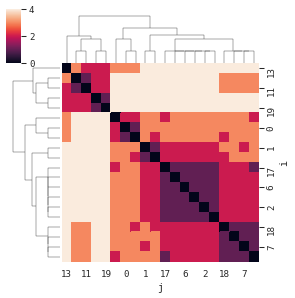

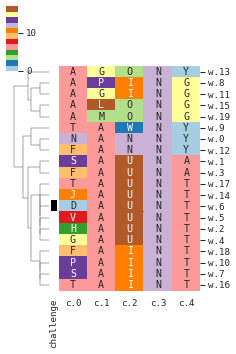

         combination  score  guess  n.uniq  exists           score.tuple
68   (F, A, I, N, T)     54  FAINT       5    True  [[54, 10], [54, 10]]
196  (S, A, I, N, T)     53  SAINT       5    True  [[53, 10], [53, 10]]
37   (A, P, I, N, G)     36  APING       5    True    [[36, 6], [36, 6]]
26   (A, G, O, N, Y)     34  AGONY       5    True    [[34, 3], [34, 3]]
57   (A, M, O, N, G)     33  AMONG       5    True    [[33, 5], [33, 5]]
128  (T, A, U, N, T)     56  TAUNT       4    True  [[56, 10], [56, 10]]
132  (T, A, I, N, T)     54  TAINT       4    True  [[54, 10], [54, 10]]
67   (F, A, U, N, A)     48  FAUNA       4    True  [[48, 20], [48, 20]]
195  (S, A, U, N, A)     47  SAUNA       4    True  [[47, 20], [47, 20]]
78   (F, A, N, N, Y)     44  FANNY       4    True    [[44, 7], [44, 7]]


GUESS # 2 FAINT left 6


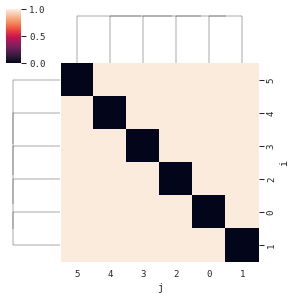

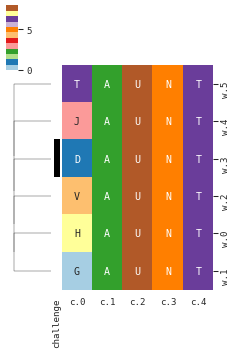

       combination  score  guess  n.uniq  exists         score.tuple
0  (J, A, U, N, T)     25  JAUNT       5    True  [[25, 1], [25, 1]]
1  (H, A, U, N, T)     25  HAUNT       5    True  [[25, 1], [25, 1]]
2  (G, A, U, N, T)     25  GAUNT       5    True  [[25, 1], [25, 1]]
3  (T, A, U, N, T)     25  TAUNT       4    True  [[25, 1], [25, 1]]


GUESS # 3 JAUNT left 5


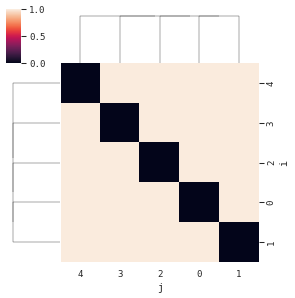

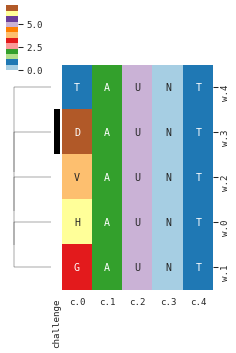

       combination  score  guess  n.uniq  exists         score.tuple
0  (H, A, U, N, T)     21  HAUNT       5    True  [[21, 1], [21, 1]]
1  (G, A, U, N, T)     21  GAUNT       5    True  [[21, 1], [21, 1]]
3  (D, A, U, N, T)     21  DAUNT       5    True  [[21, 1], [21, 1]]
2  (T, A, U, N, T)     21  TAUNT       4    True  [[21, 1], [21, 1]]


GUESS # 4 HAUNT left 4


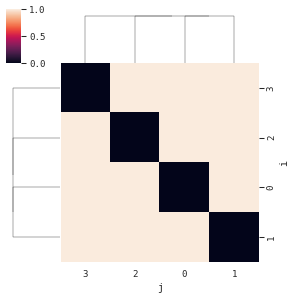

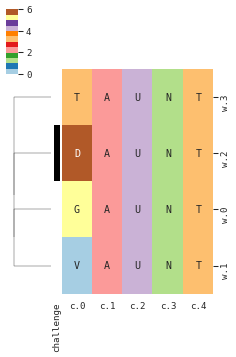

       combination  score  guess  n.uniq  exists         score.tuple
0  (G, A, U, N, T)     17  GAUNT       5    True  [[17, 1], [17, 1]]
2  (D, A, U, N, T)     17  DAUNT       5    True  [[17, 1], [17, 1]]
3  (V, A, U, N, T)     17  VAUNT       5    True  [[17, 1], [17, 1]]
1  (T, A, U, N, T)     17  TAUNT       4    True  [[17, 1], [17, 1]]


GUESS # 5 GAUNT left 3


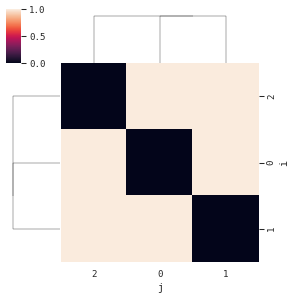

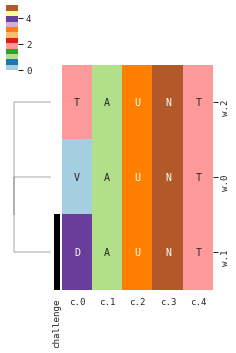

day 7 done...


total guesses 5


In [2636]:

query_day_i = 10
idx = query_day_i * 2 + 2

print('')
# print(next_args[idx])
print('')
run_query(next_args[idx][0], next_args[idx][1], next_args[idx][2], plot=True, log=True)

#### Define the number of cores to be used (e.g. 2, based on device)

In [2637]:
n_cores = 7

In [2638]:
len(next_args)

600

In [ ]:
manager = multiprocessing.Manager()
return_dict = manager.dict()
ThreadingUtils.run(run_query, next_args, n_cores=n_cores, input_list_kwargs=[{} for args in next_args])

run function <function run_query at 0x7f78a6428710> with n_cores = 7
<function run_query at 0x7f78a6428710>
# Total groups 86
Current group 0 (start/end) 0 7
Current group 10 (start/end) 70 77
Current group 20 (start/end) 140 147
Current group 30 (start/end) 210 217
Current group 40 (start/end) 280 287
Current group 50 (start/end) 350 357
Current group 60 (start/end) 420 427
Current group 70 (start/end) 490 497


### Visualize results

In [ ]:
final_scores = []
for k in return_dict.keys():
    # print(k)
    # print(k, return_dict[k])
    next_scores = return_dict[k]
    
    final_scores.append(next_scores)

res.sort_values('n.guesses', ascending=False).head()
res = pd.DataFrame(final_scores, columns=['day.i', 'strategy', 'sort.ascending', 'word', 'n.guesses'])

# matrix format
m = res.pivot('word', 'strategy', 'n.guesses')


#### Visualizing number of guesses by strategy

In [ ]:
m

In [ ]:
m['diff'] = m['letter.frequency.position.with.covariation'] - m['letter.frequency.position']
m.sort_values('diff', ascending=False).head()

In [ ]:
m.sort_values('diff', ascending=False).tail()

In [ ]:
res.groupby('strategy').mean()[['n.guesses']]

In [ ]:
sns.boxplot(data=res, x='strategy', y='n.guesses')
sns.displot(data=res, x='n.guesses', hue='strategy')


In [ ]:
plt.scatter(m['freq.and.pos'], m['freq'])
plt.xlabel('freq.n.pos')
plt.ylabel('letter frequency')
plt.plot([0, 5], [0, 5])